# Bayesian Neural Networks

We used a [github repo](https://github.com/kumar-shridhar/PyTorch-BayesianCNN)...

Below is code that imports the libraries, sets the device, imports the data, transforms the 

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
torchvision.disable_beta_transforms_warning()
import torchvision.transforms.v2 as transforms
import torch.utils.tensorboard as tb
import torch.nn.functional as F
# Code from paper
from BCNN.layers.misc import ModuleWrapper
from BCNN.layers.BBB import BBBConv
from BCNN.layers.BBB import BBBLinear

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineRenderer.figure_format = 'retina'

log_dir = 'logs'

device = None
if not torch.backends.mps.is_available(): # Check if mac
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # For GPU
else:
    device = torch.device("mps") # For GPU

print(f"Using device: {device}")

transform = transforms.Compose([
    transforms.ToImage(),
    transforms.ConvertImageDtype(),
    # Depending on your torchvision version you may need to change these:
    # - If you don't have torchvision.transforms.v2, then import torchvision.transforms
    #   instead and use ToTensor() to replace _both_ of the transforms above.
    # - If you have v2 but it says ToImage() is undefined, then use ToImageTensor() instead.
])

cifar = torchvision.datasets.CIFAR10("cifar", download=True, transform=transform) # Download data
train_size = int(0.9 * len(cifar)) # 90/10 split of data
train_data, valid_data = torch.utils.data.random_split(cifar, [train_size, len(cifar) - train_size])

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

mean = []
for x, _ in cifar:
    mean.append(torch.mean(x, dim=(1, 2)))
mean = torch.stack(mean, dim=0).mean(dim=0)
std = []
for x, _ in cifar:
    std.append(((x - mean[:,np.newaxis,np.newaxis]) ** 2).mean(dim=(1, 2)))
std = torch.stack(std, dim=0).mean(dim=0).sqrt()

cifar_mean = (0.4914, 0.4822, 0.4465)
cifar_std = (0.2470, 0.2435, 0.2616)

normalize = transforms.Normalize(cifar_mean, cifar_std)

augments = transforms.Compose([
            transforms.RandomHorizontalFlip(0.05),
            transforms.RandomGrayscale(0.03),
            transforms.ColorJitter(
                brightness=0.08,
                contrast=0.031,
                saturation=0.031,
                hue=0),
            transforms.Normalize(cifar_mean, cifar_std)
        ])

def train(model_class, 
            model_type,
          lr=1e-3, 
          epochs=10,
          reg=0,
          train_batch_size=32, 
          val_batch_size = 1000):
 
    data_loader = torch.utils.data.DataLoader(train_data, batch_size=train_batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=val_batch_size, shuffle=False)

    train_accs = []
    valid_accs = []
    
    network = model_class().to(device)
    logger = tb.SummaryWriter(log_dir + '/' + model_type + '-lr-' + str(lr) + '-epochs-' + str(epochs))
    loss = nn.CrossEntropyLoss()

    opt = optim.AdamW(network.parameters(), lr=lr, weight_decay=reg)
    scheduler = optim.lr_scheduler.StepLR(opt, step_size=20, gamma=0.85)

    global_step = 0
    for i in range(epochs):


        train_acc = []
        network.train()
        # The data loader makes batching easy
        for batch_xs, batch_ys in data_loader:
            batch_xs = batch_xs.to(device)
            preds = network(augments(batch_xs))
            loss_val = loss(preds, batch_ys.to(device))


            # Reset the gradients of all of parameters
            opt.zero_grad()
            # backward() call computes gradients using backpropagation
            loss_val.backward()
            # step() changes the parameters.
            opt.step()
            preds = network(normalize(batch_xs))
            train_acc.append((preds.argmax(dim=1) == batch_ys.to(device)).float().mean())
            # Logging
            logger.add_scalar('loss', loss_val, global_step=global_step)
            logger.add_scalar('training accuracy', (preds.argmax(dim=1) == batch_ys.to(device)).float().mean(), global_step=global_step)
            global_step += 1
            
        train_accs = np.mean([tensor.item() for tensor in train_acc])

        # Mesaure the validation accuracy.
        network.eval()
        val_acc = []
        for batch_xs, batch_ys in valid_loader:
            preds = network(normalize(batch_xs.to(device)))
            val_acc.append((preds.argmax(dim=1) == batch_ys.to(device)).float().mean())
        
        valid_accs = np.mean([tensor.item() for tensor in val_acc])
        logger.add_scalar('validation accuracy', valid_accs, global_step=global_step)

        scheduler.step()
        
        print("Epoch:", i + 1, "\nTrain accuracy:", train_accs, "\nValidation accuracy", valid_accs, "\n--------------------------------------------")

    return network

Using device: cuda
Files already downloaded and verified


# Models

Below is the code that defines out CNN and a bayesian CNN model. They are intentionally a similar structure. 

In [9]:
class CNN(nn.Module):
    def __init__(self, arch=None, activation=F.relu):
        super().__init__()
        # Code from pytorch site
        self.activation = activation
        self.conv1 =  nn.Conv2d(3, 6, 5) # Could also add stridding and padding, but not for this dataset
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.dropout = nn.Dropout(0.05)

    def forward(self, x):
        x = self.pool(self.activation(self.conv1(x)))
        x = self.pool(self.activation(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.dropout(x)
        x = self.activation(self.fc1(x))
        x = self.dropout(x)
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x

In [10]:
class BNN(ModuleWrapper):
  def __init__(self, activation=F.relu):
    super().__init__()
    self.activation = activation
    self.conv1 = BBBConv.BBBConv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = BBBConv.BBBConv2d(6, 16, 5)
    self.fc1 = BBBLinear.BBBLinear(16 * 5 * 5, 120)
    self.fc2 = BBBLinear.BBBLinear(120, 84)
    self.fc3 = BBBLinear.BBBLinear(84, 10)
    self.dropout = nn.Dropout(0.05)


  def forward(self, x):
    x = self.pool(self.activation(self.conv1(x)))
    x = self.pool(self.activation(self.conv2(x)))
    x = torch.flatten(x, 1) # flatten all dimensions except batch
    x = self.dropout(x)
    x = self.activation(self.fc1(x))
    x = self.dropout(x)
    x = self.activation(self.fc2(x))
    x = self.fc3(x)
    return x

# Training

The below trains the models... 

In [12]:
cnn_model = train( model_class=CNN, 
                    model_type = "CNN", 
                    lr=4e-4, 
                    reg=0.0001,
                    epochs=50, 
                    train_batch_size=32, 
                    val_batch_size = 5000)

Epoch: 1 
Train accuracy: 0.3869047619047619 
Validation accuracy 0.45260000228881836 
--------------------------------------------
Epoch: 2 
Train accuracy: 0.49657960199004975 
Validation accuracy 0.4989999830722809 
--------------------------------------------
Epoch: 3 
Train accuracy: 0.5398009950248757 
Validation accuracy 0.5424000024795532 
--------------------------------------------
Epoch: 4 
Train accuracy: 0.5709177327647477 
Validation accuracy 0.574999988079071 
--------------------------------------------
Epoch: 5 
Train accuracy: 0.5964818763326226 
Validation accuracy 0.5916000008583069 
--------------------------------------------
Epoch: 6 
Train accuracy: 0.611429459843639 
Validation accuracy 0.5867999792098999 
--------------------------------------------
Epoch: 7 
Train accuracy: 0.6283537668798863 
Validation accuracy 0.6065999865531921 
--------------------------------------------
Epoch: 8 
Train accuracy: 0.6410581023454158 
Validation accuracy 0.610799968242645

In [30]:
bnn_model = train( model_class=BNN, 
                    model_type = "BNN", 
                    lr=4e-4, 
                    reg=0.0001,
                    epochs=50, 
                    train_batch_size=32, 
                    val_batch_size = 5000)

Epoch: 1 
Train accuracy: 0.2271455223880597 
Validation accuracy 0.3263999819755554 
--------------------------------------------
Epoch: 2 
Train accuracy: 0.3449271499644634 
Validation accuracy 0.3718000054359436 
--------------------------------------------
Epoch: 3 
Train accuracy: 0.38348436389481166 
Validation accuracy 0.41119998693466187 
--------------------------------------------
Epoch: 4 
Train accuracy: 0.4122912224591329 
Validation accuracy 0.41599997878074646 
--------------------------------------------
Epoch: 5 
Train accuracy: 0.43112562189054726 
Validation accuracy 0.4438000023365021 
--------------------------------------------
Epoch: 6 
Train accuracy: 0.44725035536602703 
Validation accuracy 0.45019999146461487 
--------------------------------------------
Epoch: 7 
Train accuracy: 0.4617315209665956 
Validation accuracy 0.47999998927116394 
--------------------------------------------
Epoch: 8 
Train accuracy: 0.48134328358208955 
Validation accuracy 0.4891999

# Save and load models

In [31]:
# torch.save(cnn_model.state_dict(), "Models/cnn_model.pt")
torch.save(bnn_model.state_dict(), "Models/bnn_model.pt")

In [ ]:
# cnn_model = CNN()
# cnn_model.load_state_dict(torch.load("models/cnn_model.pt", map_location= device ))

# bnn_model = BNN()
# bnn_model.load_state_dict(torch.load("models/bnn_model.pt", map_location = device ))

# Check and Demo models 

In [ ]:
%reload_ext tensorboard

# Load the tensorboard extension for Jupyter
%load_ext tensorboard
# Start tensorboard and tell it where to look for logs. It will auto-update every second.
%tensorboard --logdir {log_dir} --reload_interval 1 

In [32]:
# This section runs predictions on data
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=5000, shuffle=False)

cnn_model.eval() # set model to eval mode
bnn_model.eval() # set model to eval mode

actual = []
cnn_preds = []
bnn_preds = []

for batch_xs, batch_ys in valid_loader:
    cnn_preds += cnn_model(normalize(batch_xs.to(device))).argmax(dim=1).tolist()
    actual += batch_ys.tolist()

for batch_xs, _ in valid_loader:
    bnn_preds += bnn_model(normalize(batch_xs.to(device))).argmax(dim=1).tolist()

[]

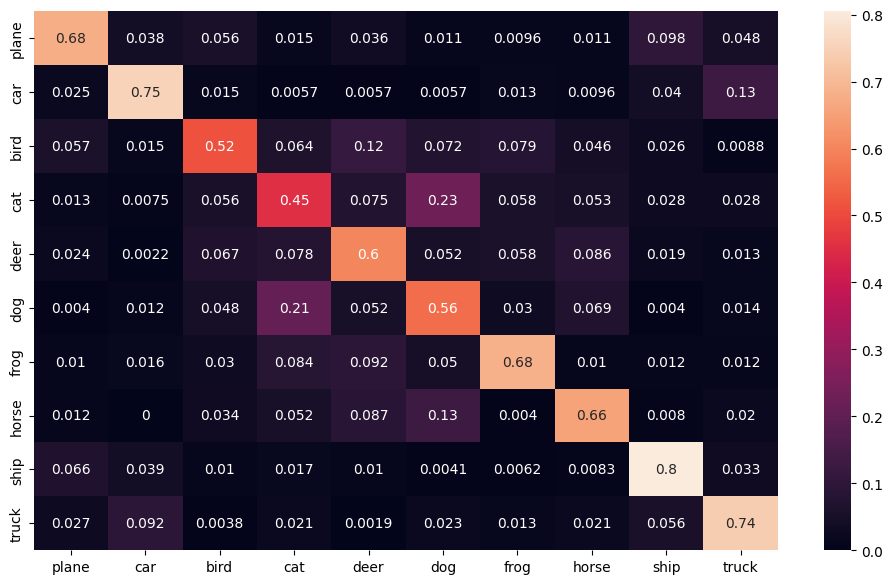

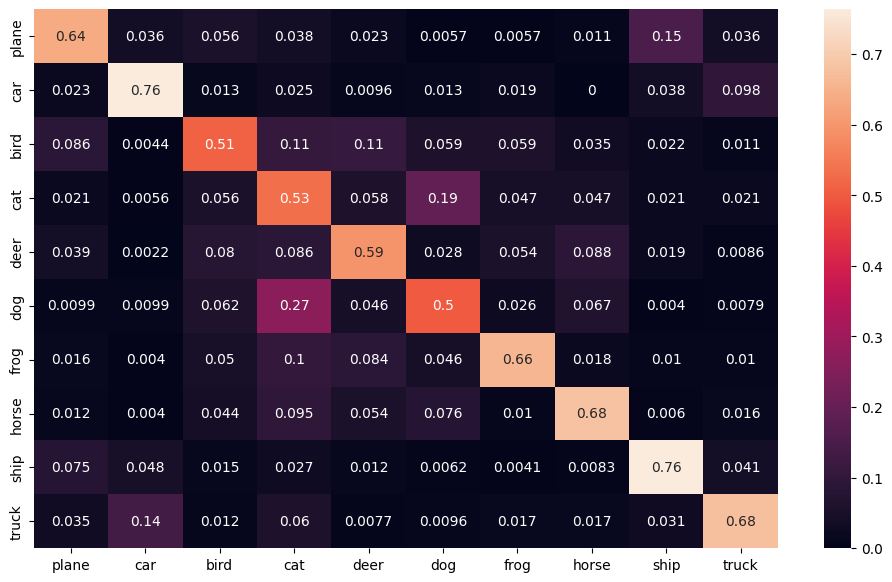

In [38]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

cnn_cf_matrix = confusion_matrix(actual, cnn_preds)
bnn_cf_matrix = confusion_matrix(actual, bnn_preds)

df_cnn_cm = pd.DataFrame(cnn_cf_matrix / np.sum(cnn_cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])

df_bnn_cm = pd.DataFrame(bnn_cf_matrix / np.sum(bnn_cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])

plt.figure(figsize = (12,7))
sn.heatmap(df_cnn_cm, annot=True)
plt.savefig('Images/CNN_confusion_matrix.png', transparent=True)
plt.plot()

plt.figure(figsize = (12,7))
sn.heatmap(df_bnn_cm, annot=True)
plt.savefig('Images/BNN_confusion_matrix.png', transparent=True)
plt.plot()